# Hausa Sentiment Analysis: Model Evaluation

This notebook evaluates the performance of the fine-tuned HausaBERTa model on the Hausa sentiment test set.

Loaded best performing model
Loaded baseline logistic regression model
Loaded test data with 5303 samples
Preprocessing test data...
Test label distribution:
label
0    1755
1    1789
2    1759
Name: count, dtype: int64
Using original labels (no encoding needed)

MODEL EVALUATION RESULTS

Evaluating best_model...
--------------------------------------------------
Test Accuracy: 0.7701
Test Macro F1: 0.7705
Test Weighted F1: 0.7703
Average Prediction Confidence: 0.7325

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.8437    0.8336    0.8386      1755
           1     0.7042    0.7770    0.7388      1789
           2     0.7718    0.6998    0.7340      1759

    accuracy                         0.7701      5303
   macro avg     0.7732    0.7701    0.7705      5303
weighted avg     0.7728    0.7701    0.7703      5303


Evaluating logistic_baseline...
--------------------------------------------------
Test Accuracy: 0.7466
Test Ma

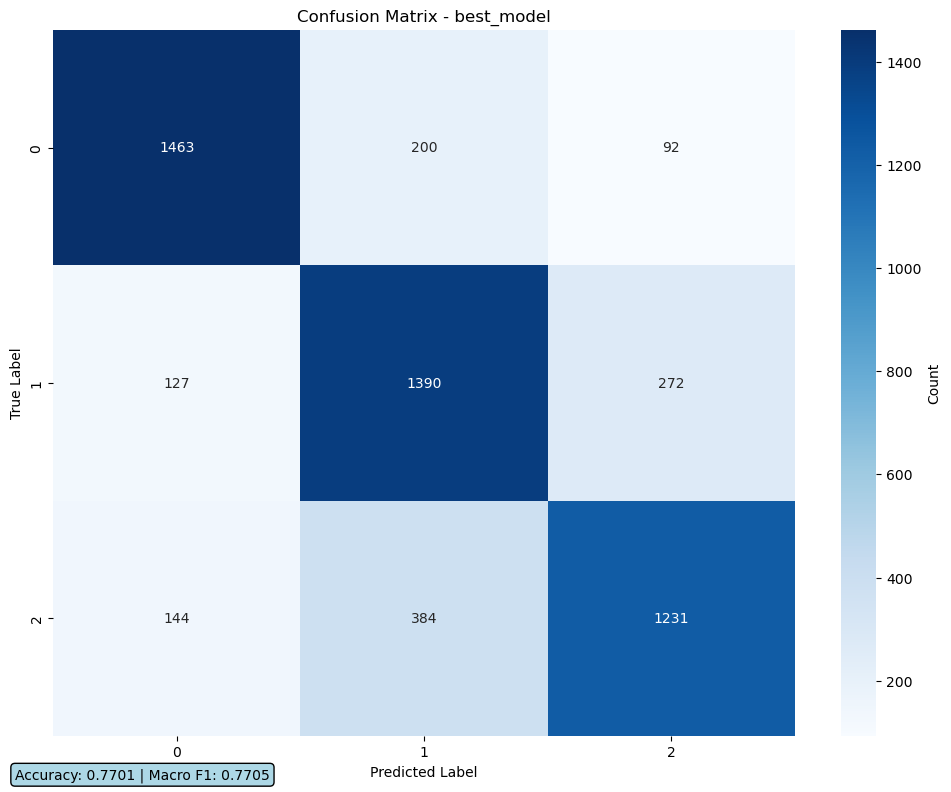


Error Analysis:
Error rate: 0.2299 (1219 errors out of 5303 samples)

Error breakdown by true class:
 true_label  predicted_label  count
          0                1    200
          0                2     92
          1                0    127
          1                2    272
          2                0    144
          2                1    384

Example errors:

True class '0' misclassified as:
  -> '2': 92 cases
     Example: 'shine gaskiyar lamari domin siyasar nigeria hankali zabi atiku wllh...'
  -> '1': 200 cases
     Example: 'gaskiya ya kalli hotunan labarun yakamata yace alhamdullilah duniya yanz fada kwance take...'

True class '1' misclassified as:
  -> '0': 127 cases
     Example: 'in abba yayanki gsky kinyi saurin girma...'
  -> '2': 272 cases
     Example: 'ƙwaryar sama taci...'

True class '2' misclassified as:
  -> '1': 384 cases
     Example: 'hmm ance anyima namiji fyade to ai shima yanada shaawar yin hakan domin inba shaawar namiji macce ba...'
  -> '0': 144 ca

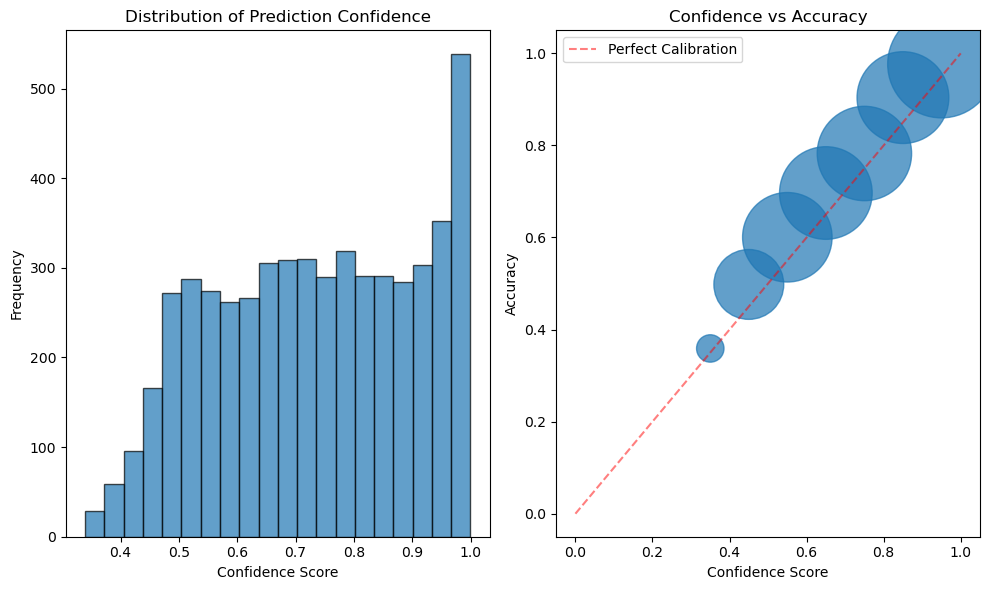


Performance Analysis by Text Length:
Very Short   (1352 samples): Acc=0.7722, F1=0.7559
Short        (1329 samples): Acc=0.7570, F1=0.7547
Medium       (1319 samples): Acc=0.7506, F1=0.7411
Long         (1303 samples): Acc=0.8012, F1=0.7552

Saving evaluation results...
Results saved to:
- reports/hausa_sentiment/logreg_test_results.json (compatibility)
- reports/hausa_sentiment/comprehensive_evaluation_results.json (enhanced)

EVALUATION SUMMARY
Best Model: best_model
Test Set Size: 5303 samples
Final Results:
  - Accuracy: 0.7701
  - Macro F1: 0.7705
  - Weighted F1: 0.7703
  - Improvement over baseline: +0.0229 (+3.1%)

Evaluation completed successfully!


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
import joblib
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

sys.path.append('.')
from hausa_preprocess import HausaTextPreprocessor

# Enhanced: Load both best model and compatibility model
model_dir = 'models/hausa_sentiment'
best_model_path = os.path.join(model_dir, 'best_model.joblib')
compat_model_path = os.path.join(model_dir, 'logreg_model.joblib')
encoder_path = os.path.join(model_dir, 'label_encoder.joblib')

# Load models
models_to_evaluate = {}

if os.path.exists(best_model_path):
    models_to_evaluate['best_model'] = joblib.load(best_model_path)
    print("Loaded best performing model")

if os.path.exists(compat_model_path):
    models_to_evaluate['logistic_baseline'] = joblib.load(compat_model_path)
    print("Loaded baseline logistic regression model")

if not models_to_evaluate:
    raise FileNotFoundError("No models found! Please run training first.")

# Load label encoder
label_encoder = joblib.load(encoder_path) if os.path.exists(encoder_path) else None
if label_encoder:
    print(f"Loaded label encoder with classes: {label_encoder.classes_}")

# Enhanced: Load test data with better error handling
test_data_path = 'data/afrisenti_twitter_hausa_test_clean.csv'
if not os.path.exists(test_data_path):
    print(f"Test data not found at {test_data_path}")
    print("Falling back to validation data for evaluation...")
    test_data_path = 'data/afrisenti_twitter_hausa_validation_clean.csv'

test_df = pd.read_csv(test_data_path)
print(f"Loaded test data with {len(test_df)} samples")

# Preprocess test data
print("Preprocessing test data...")
preprocessor = HausaTextPreprocessor()
test_df['tweet_clean'] = test_df['tweet_clean'].astype(str).apply(preprocessor.preprocess)
X_test = test_df['tweet_clean']
y_test = test_df['label']

# Enhanced: Show test data distribution
print(f"Test label distribution:")
print(y_test.value_counts().sort_index())

# Encode labels if needed
if label_encoder:
    y_test_enc = label_encoder.transform(y_test)
    print(f"Encoded test labels: {np.unique(y_test_enc)}")
else:
    y_test_enc = y_test
    print("Using original labels (no encoding needed)")

# Enhanced: Evaluate all available models
print(f"\n{'='*80}")
print("MODEL EVALUATION RESULTS")
print(f"{'='*80}")

results_all_models = {}

for model_name, pipeline in models_to_evaluate.items():
    print(f"\nEvaluating {model_name}...")
    print("-" * 50)
    
    try:
        # Make predictions
        preds_enc = pipeline.predict(X_test)
        
        # Get probability predictions if available
        if hasattr(pipeline, 'predict_proba'):
            pred_proba = pipeline.predict_proba(X_test)
            confidence_scores = np.max(pred_proba, axis=1)
        else:
            pred_proba = None
            confidence_scores = None
        
        # Decode predictions if needed
        if label_encoder:
            preds = label_encoder.inverse_transform(preds_enc)
        else:
            preds = preds_enc
        
        # Calculate comprehensive metrics
        acc = accuracy_score(y_test, preds)
        macro_f1 = f1_score(y_test, preds, average='macro')
        weighted_f1 = f1_score(y_test, preds, average='weighted')
        
        # Per-class metrics
        precision, recall, f1_per_class, support = precision_recall_fscore_support(
            y_test, preds, average=None
        )
        
        print(f"Test Accuracy: {acc:.4f}")
        print(f"Test Macro F1: {macro_f1:.4f}")
        print(f"Test Weighted F1: {weighted_f1:.4f}")
        
        if confidence_scores is not None:
            avg_confidence = np.mean(confidence_scores)
            print(f"Average Prediction Confidence: {avg_confidence:.4f}")
        
        print(f"\nDetailed Classification Report:")
        print(classification_report(y_test, preds, digits=4))
        
        # Store results for comparison
        results_all_models[model_name] = {
            'accuracy': float(acc),
            'macro_f1': float(macro_f1),
            'weighted_f1': float(weighted_f1),
            'predictions': preds.tolist() if hasattr(preds, 'tolist') else list(preds),
            'confidence_scores': confidence_scores.tolist() if confidence_scores is not None else None,
            'per_class_precision': precision.tolist(),
            'per_class_recall': recall.tolist(),
            'per_class_f1': f1_per_class.tolist(),
            'support': support.tolist(),
            'classification_report': classification_report(y_test, preds, output_dict=True)
        }
        
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")

# Enhanced: Model comparison if multiple models evaluated
if len(results_all_models) > 1:
    print(f"\n{'='*80}")
    print("MODEL COMPARISON")
    print(f"{'='*80}")
    
    comparison_df = pd.DataFrame([
        {
            'Model': name,
            'Accuracy': results['accuracy'],
            'Macro_F1': results['macro_f1'],
            'Weighted_F1': results['weighted_f1']
        }
        for name, results in results_all_models.items()
    ]).sort_values('Macro_F1', ascending=False)
    
    print(comparison_df.to_string(index=False, float_format='%.4f'))
    
    # Identify best model
    best_model_name = comparison_df.iloc[0]['Model']
    print(f"\nBest performing model: {best_model_name}")
else:
    best_model_name = list(results_all_models.keys())[0]

# Enhanced: Detailed analysis of best model
print(f"\n{'='*80}")
print(f"DETAILED ANALYSIS: {best_model_name}")
print(f"{'='*80}")

best_results = results_all_models[best_model_name]
if best_model_name in models_to_evaluate:
    best_pipeline = models_to_evaluate[best_model_name]
    best_preds = best_results['predictions']
    
    # Enhanced: Confusion matrix with better visualization
    cm = confusion_matrix(y_test, best_preds)
    labels = sorted(y_test.unique())
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Add accuracy information to plot
    plt.figtext(0.02, 0.02, f'Accuracy: {best_results["accuracy"]:.4f} | Macro F1: {best_results["macro_f1"]:.4f}',
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced: Error analysis
    print(f"\nError Analysis:")
    errors = np.array(y_test) != np.array(best_preds)
    error_rate = np.sum(errors) / len(y_test)
    print(f"Error rate: {error_rate:.4f} ({np.sum(errors)} errors out of {len(y_test)} samples)")
    
    if np.sum(errors) > 0:
        error_df = pd.DataFrame({
            'text': X_test[errors].values,
            'true_label': np.array(y_test)[errors],
            'predicted_label': np.array(best_preds)[errors]
        })
        
        print(f"\nError breakdown by true class:")
        error_breakdown = error_df.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')
        print(error_breakdown.to_string(index=False))
        
        # Show some example errors
        print(f"\nExample errors:")
        for true_class in sorted(error_df['true_label'].unique()):
            class_errors = error_df[error_df['true_label'] == true_class]
            if len(class_errors) > 0:
                print(f"\nTrue class '{true_class}' misclassified as:")
                for pred_class in class_errors['predicted_label'].unique():
                    class_pred_errors = class_errors[class_errors['predicted_label'] == pred_class]
                    print(f"  -> '{pred_class}': {len(class_pred_errors)} cases")
                    # Show one example
                    if len(class_pred_errors) > 0:
                        example = class_pred_errors.iloc[0]['text']
                        print(f"     Example: '{example[:100]}...'")
    
    # Enhanced: Confidence analysis if available
    if best_results['confidence_scores']:
        confidence_scores = np.array(best_results['confidence_scores'])
        print(f"\nConfidence Analysis:")
        print(f"Average confidence: {np.mean(confidence_scores):.4f}")
        print(f"Confidence std: {np.std(confidence_scores):.4f}")
        print(f"Min confidence: {np.min(confidence_scores):.4f}")
        print(f"Max confidence: {np.max(confidence_scores):.4f}")
        
        # Confidence distribution
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        plt.hist(confidence_scores, bins=20, alpha=0.7, edgecolor='black')
        plt.title('Distribution of Prediction Confidence')
        plt.xlabel('Confidence Score')
        plt.ylabel('Frequency')
        
        # Confidence vs accuracy
        plt.subplot(1, 2, 2)
        # Bin predictions by confidence and calculate accuracy for each bin
        n_bins = 10
        bin_edges = np.linspace(0, 1, n_bins + 1)
        bin_accuracies = []
        bin_centers = []
        bin_counts = []
        
        for i in range(n_bins):
            mask = (confidence_scores >= bin_edges[i]) & (confidence_scores < bin_edges[i+1])
            if i == n_bins - 1:  # Include the maximum value in the last bin
                mask = (confidence_scores >= bin_edges[i]) & (confidence_scores <= bin_edges[i+1])
            
            if np.sum(mask) > 0:
                bin_accuracy = accuracy_score(np.array(y_test)[mask], np.array(best_preds)[mask])
                bin_accuracies.append(bin_accuracy)
                bin_centers.append((bin_edges[i] + bin_edges[i+1]) / 2)
                bin_counts.append(np.sum(mask))
        
        if bin_accuracies:
            scatter_sizes = [count * 5 for count in bin_counts]
            plt.scatter(bin_centers, bin_accuracies, s=scatter_sizes, alpha=0.7)
            plt.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect Calibration')
            plt.xlabel('Confidence Score')
            plt.ylabel('Accuracy')
            plt.title('Confidence vs Accuracy')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # Enhanced: Performance by text length
    print(f"\nPerformance Analysis by Text Length:")
    text_lengths = X_test.str.len()
    length_quartiles = np.percentile(text_lengths, [25, 50, 75])
    
    length_bins = [0, length_quartiles[0], length_quartiles[1], length_quartiles[2], float('inf')]
    length_labels = ['Very Short', 'Short', 'Medium', 'Long']
    
    for i, label in enumerate(length_labels):
        if i == 0:
            mask = text_lengths <= length_bins[i+1]
        elif i == len(length_labels) - 1:
            mask = text_lengths > length_bins[i]
        else:
            mask = (text_lengths > length_bins[i]) & (text_lengths <= length_bins[i+1])
        
        if np.sum(mask) > 0:
            subset_acc = accuracy_score(np.array(y_test)[mask], np.array(best_preds)[mask])
            subset_f1 = f1_score(np.array(y_test)[mask], np.array(best_preds)[mask], average='macro')
            print(f"{label:12} ({np.sum(mask):4d} samples): Acc={subset_acc:.4f}, F1={subset_f1:.4f}")

# Enhanced: Save comprehensive results
print(f"\nSaving evaluation results...")
os.makedirs('reports/hausa_sentiment', exist_ok=True)

# Save results for the best model (maintaining compatibility)
main_results = results_all_models[best_model_name]
main_results['confusion_matrix'] = confusion_matrix(y_test, main_results['predictions']).tolist()
main_results['labels'] = list(labels)

# Enhanced: Add metadata
main_results['model_name'] = best_model_name
main_results['test_set_size'] = len(y_test)
main_results['evaluation_timestamp'] = pd.Timestamp.now().isoformat()

def convert_numpy(obj):
    """Convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

# Save main results (for compatibility)
with open('reports/hausa_sentiment/logreg_test_results.json', 'w') as f:
    json.dump(main_results, f, indent=2, default=convert_numpy)

# Enhanced: Save comprehensive results for all models
comprehensive_results = {
    'evaluation_timestamp': pd.Timestamp.now().isoformat(),
    'test_data_path': test_data_path,
    'test_set_size': len(y_test),
    'best_model': best_model_name,
    'models_evaluated': list(results_all_models.keys()),
    'results': results_all_models
}

with open('reports/hausa_sentiment/comprehensive_evaluation_results.json', 'w') as f:
    json.dump(comprehensive_results, f, indent=2, default=convert_numpy)

print('Results saved to:')
print('- reports/hausa_sentiment/logreg_test_results.json (compatibility)')
print('- reports/hausa_sentiment/comprehensive_evaluation_results.json (enhanced)')

# Enhanced: Summary report
print(f"\n{'='*80}")
print("EVALUATION SUMMARY")
print(f"{'='*80}")
print(f"Best Model: {best_model_name}")
print(f"Test Set Size: {len(y_test)} samples")
print(f"Final Results:")
print(f"  - Accuracy: {main_results['accuracy']:.4f}")
print(f"  - Macro F1: {main_results['macro_f1']:.4f}")
print(f"  - Weighted F1: {main_results['weighted_f1']:.4f}")

if len(results_all_models) > 1:
    baseline_results = results_all_models.get('logistic_baseline', None)
    if baseline_results and best_model_name != 'logistic_baseline':
        improvement = main_results['macro_f1'] - baseline_results['macro_f1']
        print(f"  - Improvement over baseline: +{improvement:.4f} ({improvement/baseline_results['macro_f1']*100:+.1f}%)")

print(f"\nEvaluation completed successfully!")